In [57]:
import trading_strategy
import torch
import utils
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme()

In [58]:
def unif_mu(n: int, mu_min: float, mu_max: float, freq: float) -> torch.Tensor:
    """Generate n uniformly distributed mu's between mu_min and mu_max"""
    mu_annual = (mu_max - mu_min) * torch.rand(n) + mu_min
    mu_freq = mu_annual * freq
    return mu_freq

def toeplitz_cov(n: int, sigma_min: float, sigma_max: float, freq: float) -> torch.Tensor:
    """Generate a toeplitz covariance matrix with n elements and sigma_min and sigma_max"""
    sigmas_annual = (sigma_max - sigma_min) * torch.rand(n) + sigma_min
    sigmas_freq = sigmas_annual * np.sqrt(freq)
    cov = torch.zeros((n,n))
    for i in range(n):
        for j in range(i, n):
            rho = np.exp(-np.abs(i - j)/np.sqrt(n))
            cov[i,j] = rho * sigmas_freq[i] * sigmas_freq[j]
            cov[j,i] = cov[i,j]
    return cov

def generate_correlated_returns(n_points: int, mu: torch.Tensor, cov: torch.Tensor) -> torch.Tensor:
    """
    Generate n_vectors of correlated returns with mean mu and covariance cov
    """
    return torch.distributions.MultivariateNormal(mu, cov).sample((n_points,))


def generate_batch_correlated_returns(batch_size: int, n_vectors: int, mu: torch.Tensor, cov: torch.Tensor) -> torch.Tensor:
    """
    Generate n_vectors of correlated returns with mean mu and covariance cov
    """
    return torch.distributions.MultivariateNormal(mu, cov).sample((batch_size, n_vectors))


def rebuild_prices(returns: torch.Tensor, initial_price: float) -> torch.Tensor:
    """
    Rebuild prices from returns
    """
    n_points, n_assets = returns.shape
    prices = torch.zeros((n_points + 1, n_assets))
    prices[0] = initial_price
    for i in range(returns.shape[0]):
        prices[i+1] = prices[i] * (1 + returns[i])
    return prices

In [59]:
n_assets = 10 # number of assets we're trading
freq = 1/252 # daily data (so daily returns)

# we create synthetic data
mu_min, mu_max = 0.05, 0.3 # annual return
mu = unif_mu(n_assets, mu_min, mu_max, freq) # hourly return

sigma_min, sigma_max = 0.1, 0.3 # annual volatility
cov = toeplitz_cov(n_assets, sigma_min, sigma_max, freq) # hourly covariance

n_years = 1 # 1 year of data
n_points = int(n_years/freq) # number of points in the time series
returns = generate_correlated_returns(n_points, mu, cov)

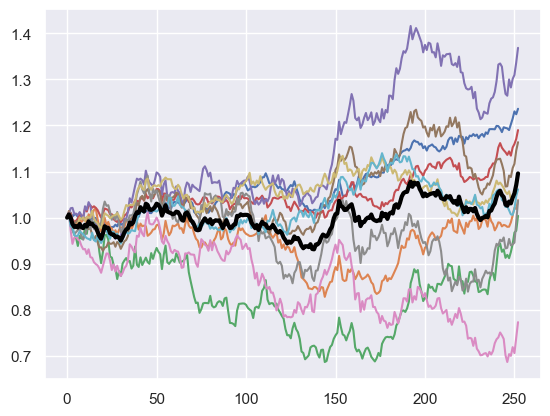

In [60]:
prices = rebuild_prices(returns, 1)
mean_price = torch.mean(prices, dim=1)
plt.plot(prices)
plt.plot(mean_price, color='black', linewidth=3)
plt.show()

## Markowitz Portfolio on this

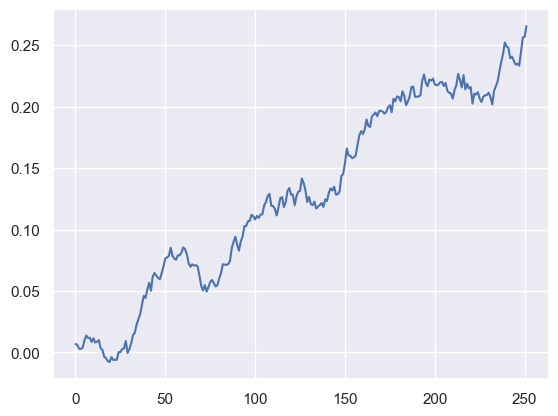

In [61]:
w = torch.inverse(cov) @ mu
w = w / torch.sum(w)

# compute returns of portfolio
portfolio_return = torch.zeros(n_points)
portfolio_pnl = torch.zeros(n_points)
for i in range(n_points):
    portfolio_return[i] = w @ returns[i, :]
    portfolio_pnl[i] = w @ (prices[i, :] * returns[i, :])

portfolio_value = torch.cumsum(portfolio_pnl, dim=0)
plt.plot(portfolio_value)
plt.show()

In [62]:
mean_daily_return = torch.mean(portfolio_return)
std_daily_return = torch.std(portfolio_return)
sharpe_ratio = mean_daily_return / std_daily_return * np.sqrt(1/freq)
print(f'Sharpe ratio: {sharpe_ratio:.2f}')

Sharpe ratio: 3.38


## Sig Trader of order 0 should yield Markowitz

In [68]:
batch_size = 10000
initial_price = 100

batch_returns = generate_batch_correlated_returns(batch_size, n_points, mu, cov)

batch_prices = torch.zeros((batch_size, n_points + 1, n_assets))
for i in range(batch_size):
    batch_prices[i] = rebuild_prices(batch_returns[i], initial_price)

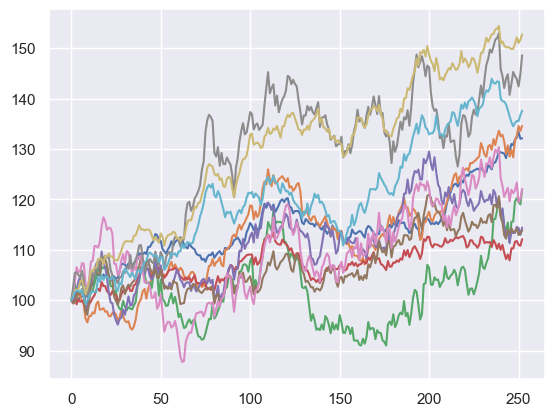

In [69]:
plt.plot(batch_prices[0])

In [64]:
# Sig Trader parameters
depth = 0
delta = 1

In [65]:
# fit with only 100 samples
n_batch = 100
ts = trading_strategy.TradingStrategy(depth, delta)
info_data = torch.zeros((n_batch, n_points + 1, 0))
ts.fit(batch_prices[:n_batch], info_data[:n_batch])
ts.print_functionals()

mu_sig successfully computed
sigma_sig successfully computed
lambda successfully computed
Fitting successful.

L_1
Level 0:
tensor([0.1001])
L_2
Level 0:
tensor([-0.0537])
L_3
Level 0:
tensor([-0.0019])
L_4
Level 0:
tensor([0.0357])
L_5
Level 0:
tensor([-0.0011])
L_6
Level 0:
tensor([0.0018])
L_7
Level 0:
tensor([0.0030])
L_8
Level 0:
tensor([-0.0173])
L_9
Level 0:
tensor([0.0614])
L_10
Level 0:
tensor([-0.0295])


In [66]:
# fit with only 100 samples
n_batch = 1000
ts = trading_strategy.TradingStrategy(depth, delta)
info_data = torch.zeros((n_batch, n_points + 1, 0))
ts.fit(batch_prices[:n_batch], info_data[:n_batch])
ts.print_functionals()

mu_sig successfully computed
sigma_sig successfully computed
lambda successfully computed
Fitting successful.

L_1
Level 0:
tensor([0.0753])
L_2
Level 0:
tensor([-0.0376])
L_3
Level 0:
tensor([-0.0058])
L_4
Level 0:
tensor([0.0423])
L_5
Level 0:
tensor([-0.0082])
L_6
Level 0:
tensor([0.0174])
L_7
Level 0:
tensor([-0.0038])
L_8
Level 0:
tensor([-0.0192])
L_9
Level 0:
tensor([0.0433])
L_10
Level 0:
tensor([-0.0044])


In [79]:
ts.functionals[2][0].value

AttributeError: 'Tensor' object has no attribute 'value'

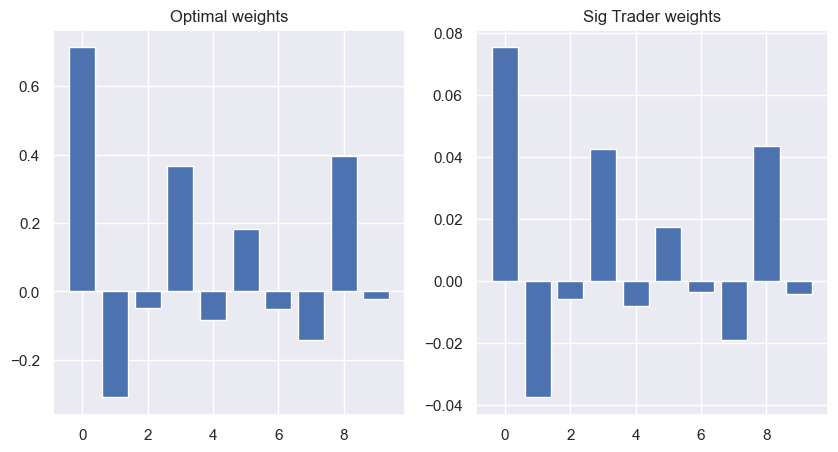

In [80]:
w_sig = [ts.functionals[i][0] for i in range(n_assets)]

# bar plot of w and w_sig
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.bar(range(n_assets), w)
plt.title('Optimal weights')
plt.subplot(1,2,2)
plt.bar(range(n_assets), w_sig)
plt.title('Sig Trader weights')
plt.show()


In [ ]:
# fit with only 10000 samples
n_batch = 10000
ts = trading_strategy.TradingStrategy(depth, delta)
info_data = torch.zeros((n_batch, n_points + 1, 0))
ts.fit(batch_prices[:n_batch], info_data[:n_batch])
ts.print_functionals()

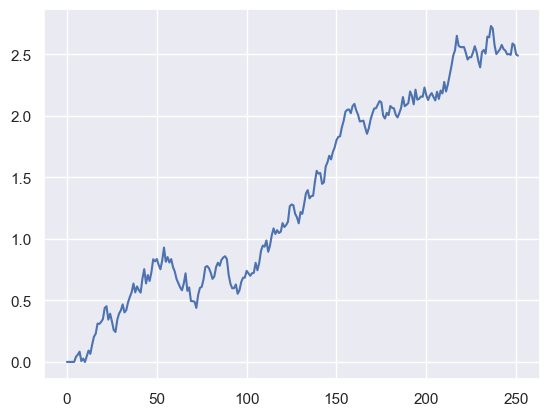

In [67]:
# let's trade
index = 0
X = batch_prices[index]
f = info_data[index]
xi = ts.trade(X, f)
daily_pnl = ts.compute_pnl(X, xi) # daily pnl on each asset
daily_global_pnl = torch.sum(daily_pnl, dim=1) # daily pnl on the portfolio
cum_global_pnl = torch.cumsum(daily_global_pnl, dim=0)

plt.figure()
plt.plot(cum_global_pnl)
plt.show()